In [2]:
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
import os

# Inital setting for plot size
from matplotlib import rcParams

In [93]:
def gem2adata(in_put, binsize, in_type='file', sep='\t'):
    import scipy.sparse as sps
    if in_type == 'file':
        df = pd.read_csv(in_put, comment='#', sep=sep)
    if in_type == 'df':
        df = in_put.copy()

    df['x'] = df['x'].apply(lambda x: int(x/binsize)*binsize)
    df['y'] = df['y'].apply(lambda x: int(x/binsize)*binsize)
        
    df['index'] = df['x'].apply(str) + '_' + df['y'].apply(str) + '@' + df['geneID']
    try:
        df = df[['index', 'MIDCounts']]
    except:
        df = df[['index', 'MIDCount']]
    
    df.columns = ['index', 'MIDCounts']

    df = df.groupby('index').sum()

    df[['index', 'geneID']] = [x.split('@') for x in df.index]
    index = df['index'].unique()
    idict = dict(zip(index, range(len(index))))
    geneID = df['geneID'].unique()
    gdict = dict(zip(geneID, range(len(geneID))))

    df['index'] = df['index'].apply(lambda x: idict[x])
    df['geneID'] = df['geneID'].apply(lambda x: gdict[x])

    csr_matrix = sps.csr_matrix((df['MIDCounts'].values, (df['index'].values, df['geneID'].values)), shape=(len(index), len(geneID)))
    adata = sc.AnnData(csr_matrix)
    adata.obs[['x', 'y']] = [x.split('_') for x in index]
    adata.obs[['x', 'y']] = adata.obs[['x', 'y']].applymap(int)
    adata.obs_names = ['DNB_' + x for x in index]
    adata.var_names = geneID
    adata.obsm['spatial'] = adata.obs[['x', 'y']].values
    return adata

def sc_qc(adata, min_genes=0, max_genes=0, mt_pct=0, min_cells=0, sc_cal=True, sc_filter=True):
    if sc_cal:
        adata.var['mt'] = adata.var_names.str.startswith('mt-')
        adata.var['rp'] = adata.var_names.str.startswith('Rpl') | adata.var_names.str.startswith('Rps')
        if adata.var['mt'].sum() == 0:
            adata.var['mt'] = adata.var_names.str.startswith('MT-')
            adata.var['rp'] = adata.var_names.str.startswith('RPL') | adata.var_names.str.startswith('RPS')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)
        
    if sc_filter:
        if min_genes > 0:
            sc.pp.filter_cells(adata, min_genes=min_genes)
        if max_genes > 0:
            sc.pp.filter_cells(adata, max_genes=max_genes)
        
        if mt_pct > 0:    
            adata = adata[adata.obs.pct_counts_mt <= mt_pct, :]
        if min_cells > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells)
    
    return adata

def reloc(adata, arrange='v', cat=None, gap=1000):
    loc = adata.obs[['x','y']].astype(float).copy()
    adata.obs['sample'] = adata.obs['sample'].astype('category')
    if cat is not None:
        adata.obs['sample'] = pd.Categorical(adata.obs['sample'], categories=cat)
    for slide in adata.obs['sample'].cat.categories:
        tmp = loc.loc[adata.obs_names[adata.obs['sample'] == slide], :].copy()
        x_range, y_range = tmp.max() - tmp.min()
        if (arrange=='v') & (x_range >= y_range):
            tmp[['x', 'y']] = tmp[['y', 'x']].to_numpy()
        if (arrange=='h') & (x_range < y_range):
            tmp[['x', 'y']] = tmp[['y', 'x']].to_numpy()
            
        x_mean = int(tmp['x'].mean())
        y_mean = int(tmp['y'].mean())
        loc.loc[tmp.index, 'x'] = tmp['x'].values - x_mean
        loc.loc[tmp.index, 'y'] = tmp['y'].values - y_mean

    #adata.obsm['X_umap_bak'] = adata.obsm['X_umap']
    adata.obsm['X_umap'] = loc.to_numpy()

    x_edge = 0
    for sample in adata.obs['sample'].cat.categories:
        tmp = adata[adata.obs['sample']==sample, :]
        r = (tmp.obsm['X_umap'][:, 0].max() - tmp.obsm['X_umap'][:, 0].min())/2
        loc.loc[tmp.obs_names, 'x'] = loc.loc[tmp.obs_names, 'x'] + x_edge + r + gap
        x_edge = loc.loc[tmp.obs_names, 'x'].max()
    loc = loc - loc.min()
    adata.obsm['X_umap'] = loc.to_numpy()
    adata.obsm['spatial'] = loc.to_numpy()
    
def spin(adata, theta, add_key='spin', **kwds):
    theta = np.radians(-theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))

    adata.obsm[add_key] = adata.obsm['spatial'].dot(R)
    # sc.pl.spatial(adata, color=['n_genes_by_counts'], basis=add_key, **kwds )
    
def regplot(df, x, y, hue=None, save=None, linewidth=0, **kwds):
    import scipy as sp
    sns.scatterplot(x=x, y=y, data=df,hue=hue,  
                    s=80, linewidth=linewidth, **kwds)
    sns.regplot(x=x, y=y, data=df, scatter=False,)

    r, p = sp.stats.pearsonr(df[x], df[y])

    ax = plt.gca()
    ax.text(.05, .8, 'r2={:.5f}, p={}'.format(r**2, p),
            transform=ax.transAxes)
    plt.legend(
        bbox_to_anchor=(1.0, 1.0),
        fontsize='small',
    )

    if save is not None:
        plt.savefig(save)
    plt.show()
    
def cal_moran(adata, n_jobs=1, use_raw=False, genes=None, **kwds):
    import squidpy as sq
    sq.gr.spatial_neighbors(adata, coord_type='grid')    
    if genes is None:
        genes = list(adata.var_names)
    sq.gr.spatial_autocorr(adata, n_jobs=n_jobs, mode='moran', use_raw=use_raw, genes=genes, **kwds)

In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)

# Saturation

In [6]:
files = os.popen('ls sequencing_saturation/*').read().split('\n')[:-1]
df_list = list()
for file in files:
    df_list.append(pd.read_csv(file, sep='\t'))

In [20]:
files

['sequencing_saturation/C04027G3_sequencing_saturation.txt',
 'sequencing_saturation/D03558A5_sequencing_saturation.txt',
 'sequencing_saturation/Y00583L7_sequencing_saturation.txt',
 'sequencing_saturation/Y00583N7_sequencing_saturation.txt']

In [32]:
for i in range(4):
    df_list[i]['unique_ratio'] = 1 - df_list[i]['bar_y1']

In [33]:
df_list[1]

sample      bar_x    bar_y1  bar_y2    bar_umi      bin_x    bin_y1  \
0     0.05   11780640  0.057286       1   11105770   11780640  0.075195   
1     0.10   23561280  0.106989       1   21040477   23561280  0.126709   
2     0.20   47122560  0.189834       1   38177105   47122560  0.209983   
3     0.30   70683840  0.256052       1   52585115   70683840  0.275608   
4     0.40   94245120  0.310206       1   65009751   94245120  0.329069   
5     0.50  117806400  0.355686       1   75904268  117806400  0.373724   
6     0.60  141367680  0.394115       1   85652565  141367680  0.411391   
7     0.70  164928960  0.427200       1   94471322  164928960  0.443757   
8     0.80  188490240  0.455999       1  102538896  188490240  0.471895   
9     0.90  212051520  0.481362       1  109978068  212051520  0.496638   
10    1.00  235612793  0.503856       1  116897761  235612793  0.518585   

    bin_y2  bin_umi  sample_reads  unique_ratio  
0     1510     2102    38000000.0      0.942714  
1     2450     3984    76000000.0      0.893011  
2     3649     7229   152000000.0      0.810166  
3     4474     9957   228000000.0      0.743948  
4     5007    12310   304000000.0      0.689794  
5     5456    14373   380000000.0      0.644314  
6     5795    16219   456000000.0      0.605885  
7     6095    17888   532000000.0      0.572800  
8     6339    19416   608000000.0      0.544001  
9     6538    20825   684000000.0      0.518638  
10    6709    22044   760000000.0      0.496144

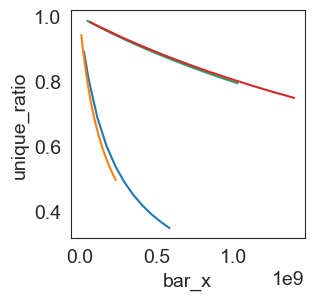

In [34]:
plt.rc("figure", figsize=(3,3))
for df in df_list:
    sns.lineplot(data=df, x='bar_x', y='unique_ratio')

plt.savefig('unique_ratio.pdf')
plt.show()

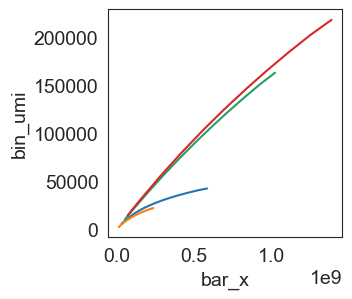

In [35]:
for df in df_list:
    sns.lineplot(data=df, x='bar_x', y='bin_umi')
plt.savefig('umi_perbin200.pdf')
plt.show()

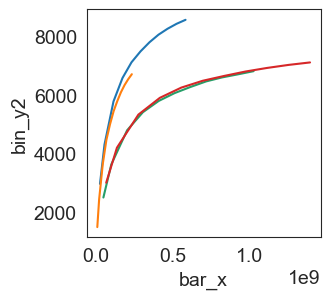

In [36]:
for df in df_list:
    sns.lineplot(data=df, x='bar_x', y='bin_y2')
plt.savefig('gene.pdf')
plt.show()

# QC

In [5]:
files = os.popen('ls gem/*gem.gz').read().split('\n')[:-1]
bin200 = list()
for file in files:
    sample = os.path.basename(file).split('.')[0]
    adata = gem2adata(file, binsize=200)
    adata.obs['sample'] = sample
    adata.obs_names = [sample +'@' + x for x in adata.obs_names]
    bin200.append(adata)

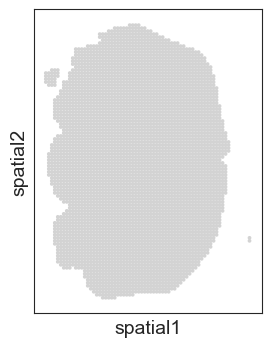

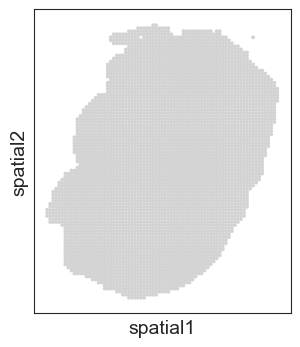

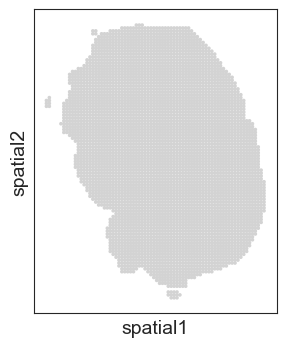

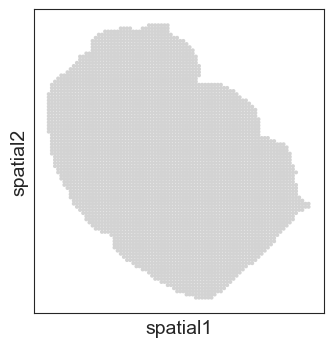

In [6]:
for adata in bin200:
    sc.pl.spatial(adata, spot_size=250)

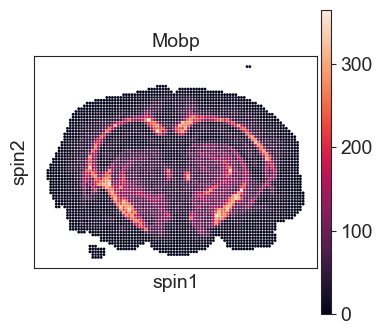

In [7]:
spin(bin200[0], theta=-90)
sc.pl.spatial(bin200[0], color='Mobp',spot_size=200, basis='spin')

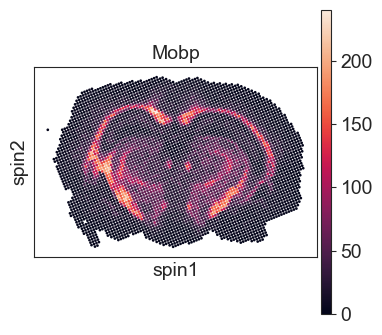

In [8]:
spin(bin200[1], theta=-112)
sc.pl.spatial(bin200[1], color='Mobp',spot_size=200, basis='spin')

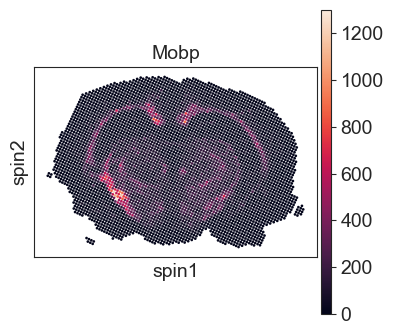

In [9]:
spin(bin200[2], theta=-65)
sc.pl.spatial(bin200[2], color='Mobp',spot_size=200, basis='spin')

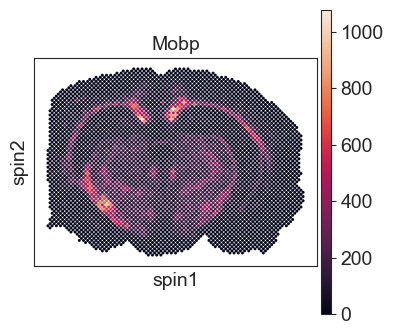

In [10]:
spin(bin200[3], theta=135)
sc.pl.spatial(bin200[3], color='Mobp',spot_size=200, basis='spin')

In [11]:
adata = sc.concat(bin200, join='outer')
adata.layers['counts'] = adata.X.copy()

In [12]:
adata = sc_qc(adata, min_genes=400, mt_pct=10, min_cells=20)

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:278: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


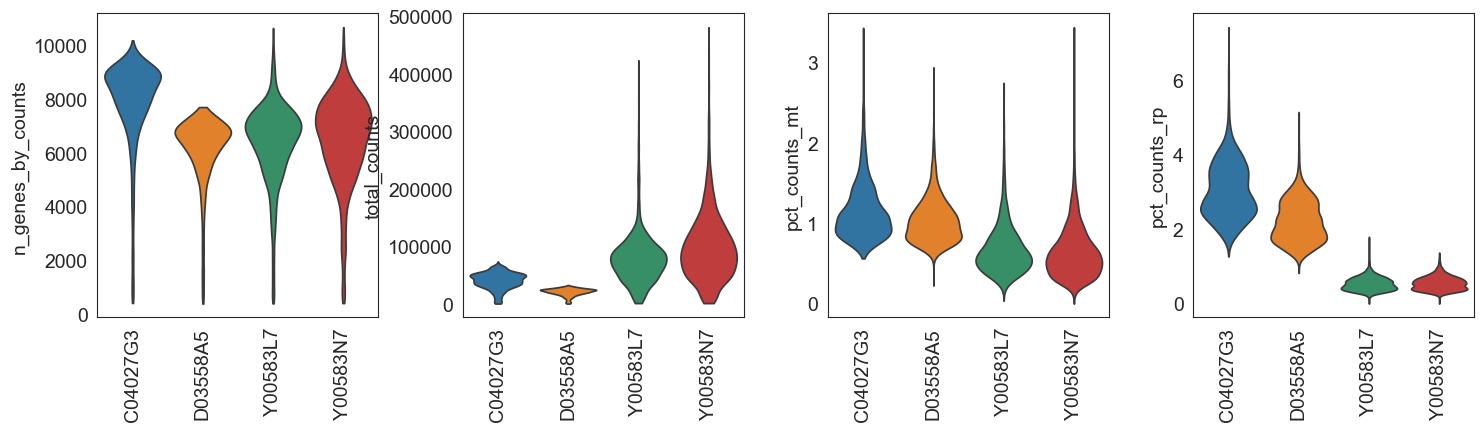

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rp'], 
             jitter=0.4, groupby='sample', multi_panel=False, size=1, stripplot=False, save='bin200.pdf', rotation=90)

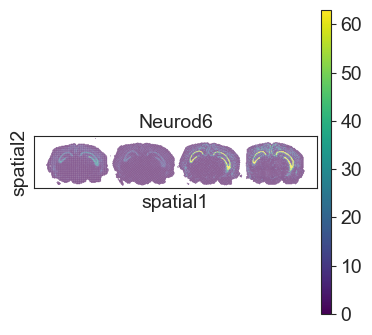

In [14]:
adata.obs[['x', 'y']] = adata.obsm['spin']
reloc(adata, arrange='h')
sc.pl.spatial(adata, color='Neurod6', cmap='viridis', vmax='p99', spot_size=200)

# bulk comparison

In [15]:
rlist = list()
chips = ['D03558A5', 'C04027G3','Y00583N7', 'Y00583L7']
for chip in chips:
    tmp = adata[adata.obs['sample']==chip]
    bulk = np.array(tmp.X.sum(axis=0))[0, :]
    rlist.append(pd.Series(bulk, index=tmp.var_names))
df = pd.concat(rlist, axis=1)
df.columns=chips
df

D03558A5  C04027G3  Y00583N7  Y00583L7
0610005C13Rik       167       264        43        68
0610006L08Rik         6         6        26        28
0610009B22Rik      3800      7697      4126      3299
0610009O20Rik      1884      3172      7931      6259
0610010F05Rik      5205      8429     45392     35668
...                 ...       ...       ...       ...
mt-Nd3             1087      2754       439       410
mt-Nd4           210807    388505    209496    177284
mt-Nd4l               5        14        85        74
mt-Nd5            25831     50309    361121    302502
mt-Nd6             3967      7590     63129     53152

[22964 rows x 4 columns]

In [16]:
df = df * 1e6 / df.sum()
df = df.applymap(np.log1p)
df

D03558A5  C04027G3  Y00583N7  Y00583L7
0610005C13Rik  0.986161  0.911356  0.090538  0.173237
0610006L08Rik  0.058639  0.033252  0.055717  0.075000
0610009B22Rik  3.669914  3.792657  2.311823  2.320074
0610009O20Rik  2.993892  2.937831  2.916592  2.912889
0610010F05Rik  3.977632  3.881546  4.615458  4.607302
...                 ...       ...       ...       ...
mt-Nd3         2.479986  2.804532  0.676744  0.761015
mt-Nd4         7.660519  7.691796  6.137043  6.202798
mt-Nd4l        0.049102  0.075935  0.171700  0.187174
mt-Nd5         5.564519  5.650738  6.680644  6.736295
mt-Nd6         3.711850  3.778976  4.942518  5.002916

[22964 rows x 4 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


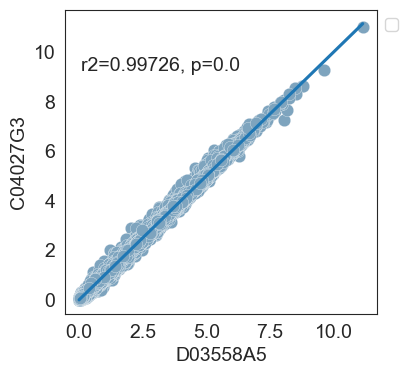

In [17]:
regplot(df=df, x='D03558A5', y='C04027G3',c='#7EA4BE', linewidth=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


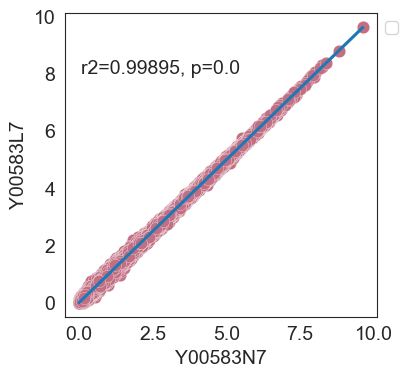

In [18]:
regplot(df=df, x='Y00583N7', y='Y00583L7', c='#C26F83', linewidth=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


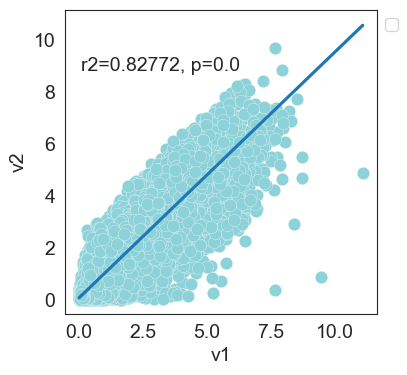

In [19]:
df['v1'] = df[['D03558A5', 'C04027G3']].mean(axis=1)
df['v2'] = df[['Y00583N7', 'Y00583L7']].mean(axis=1)
regplot(df=df, x='v1', y='v2', linewidth=0.2, c='#8DD2D9')

In [21]:
tf = pd.read_excel('merfish/41586_2023_6812_MOESM6_ESM.xlsx', sheet_name='transcription_factors', header=None)[0]
tf = list(set(tf) & set(df.index))
len(tf)

503

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


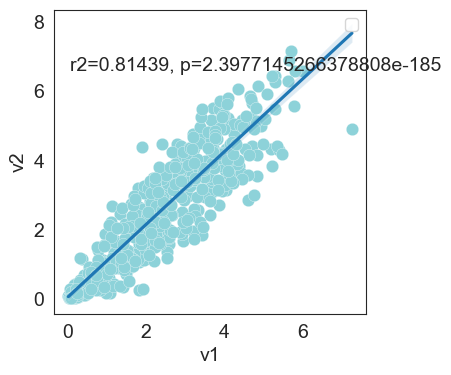

In [22]:
regplot(df=df.loc[tf,:], x='v1', y='v2', linewidth=0.2, c='#8DD2D9')

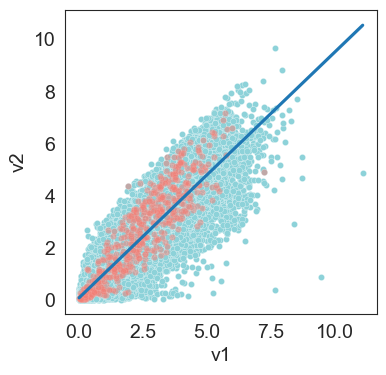

In [23]:
from scipy import stats
fig, ax = plt.subplots()

sns.scatterplot(x='v1', y='v2', data=df, s=20,  linewidth=0.2, ax=ax, c='#8DD2D9')
sns.regplot(x='v1', y='v2', data=df, scatter=False, ax=ax)

sns.scatterplot(x='v1', y='v2', data=df.loc[tf,:], s=20, linewidth=0.1, ax=ax, alpha=0.5, c='#f37f76')
plt.savefig('v1_v2_tf.pdf')

In [25]:
de = pd.read_excel('merfish/41586_2023_6812_MOESM6_ESM.xlsx', sheet_name='DE_gene_list', header=None)[0]
de = list(set(de) & set(df.index))
len(de)

7942

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


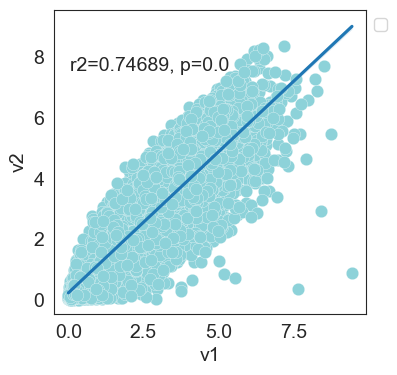

In [27]:
regplot(df=df.loc[de,:], x='v1', y='v2', linewidth=0.2, c='#8DD2D9', save='v1_v2_de.pdf')

In [28]:
func = pd.read_excel('merfish/41586_2023_6812_MOESM6_ESM.xlsx', sheet_name='functional_genes', header=None)[0]
func = list(set(func) & set(df.index))
len(func)

533

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


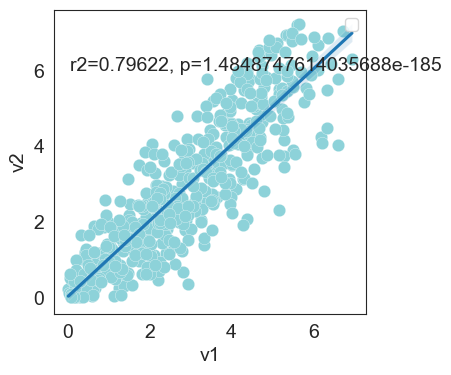

In [29]:
regplot(df=df.loc[func,:], x='v1', y='v2', linewidth=0.2, c='#8DD2D9', save='v1_v2_func.pdf')

In [30]:
ad = pd.read_excel('merfish/41586_2023_6812_MOESM6_ESM.xlsx', sheet_name='adhesion_genes', header=None)[0]
ad = list(set(ad) & set(df.index))
len(ad)

843

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


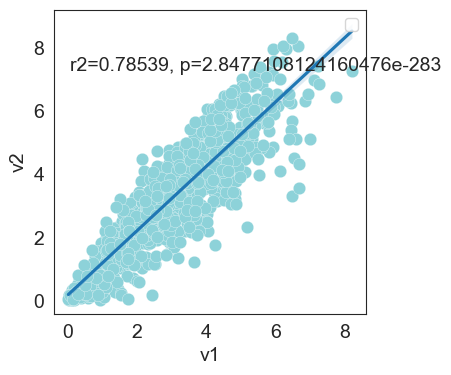

In [31]:
regplot(df=df.loc[ad,:], x='v1', y='v2', linewidth=0.2, c='#8DD2D9', save='v1_v2_ad.pdf')

In [33]:
adata.write('v1_v2_raw.h5ad')

# compare with merfish

In [35]:
mer = sc.read_h5ad('merfish/Zhuang-ABCA-1-raw.h5ad')
meta = pd.read_csv('merfish/cell_metadata.csv.gz')

In [36]:
mer = mer[meta['cell_label'].values, :]
mer.obs = meta
mer.obsm['spatial'] = mer.obs[['x', 'y']].values
mer.var_names = mer.var['gene_symbol'].values

In [37]:
mer.obs_names = [str(x) for x in mer.obs_names]

In [40]:
# mer.write('merfish/Zhuang1_raw.h5ad')
mer = sc.read_h5ad('merfish/Zhuang1_raw.h5ad')

In [154]:
# mer2 = sc.read_h5ad('/home/lixinxing/V2/diffusion/MERFISH/zhuang/Zhuang-ABCA-2-raw.h5ad')
# meta2 = pd.read_csv('/home/lixinxing/V2/diffusion/MERFISH/zhuang/cell_metadata.csv')

# mer2 = mer2[meta2['cell_label'].values, :]
# mer2.obs = meta2
# mer2.obsm['spatial'] = mer2.obs[['x', 'y']].values
# mer2.var_names = mer2.var['gene_symbol'].values

# mer2.obs_names = [str(x) for x in mer2.obs_names]
# mer2.write('merfish/Zhuang2_raw.h5ad')

In [198]:
for slide in mer.obs['brain_section_label'].unique():
    sc.pl.spatial(mer[mer.obs['brain_section_label']==slide], color='Neurod6', spot_size=0.08, cmap='viridis', vmax='p99', save=f'{slide}.pdf', show=False)
    

In [41]:
sub1 = mer[mer.obs['brain_section_label'].isin(['Zhuang-ABCA-1.088','Zhuang-ABCA-1.089'])].copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


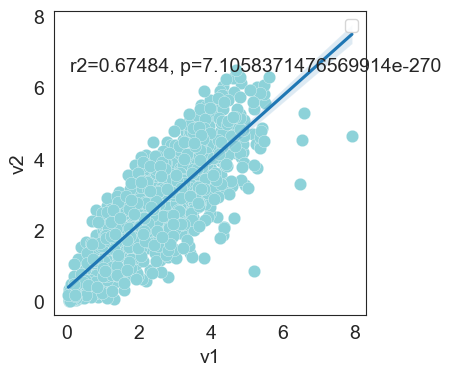

In [45]:
genes = list(set(sub1.var_names) & set(df.index))
regplot(df=df.loc[genes,:], x='v1', y='v2', linewidth=0.2, c='#8DD2D9')

In [ ]:
# mer = sc.read_h5ad('/home/lixinxing/V2/diffusion/MERFISH/merfish_ffpe.h5ad')
mer = mer[:, genes]

In [49]:
sub1 = sub1[:, genes]
bulk = np.array(sub1.X.sum(axis=0))
bulk = bulk * 1e6 / bulk.sum()
bulk = np.log1p(bulk)

In [51]:
df2 = df.loc[genes,:].copy()
df2['merfish'] = bulk
df2

D03558A5  C04027G3  Y00583N7  Y00583L7        v1        v2  \
Tmem215        2.487544  2.518606  1.895685  1.932288  2.503075  1.913987   
Dcdc2a         2.542080  2.587888  3.242280  3.176815  2.564984  3.209548   
Pde11a         1.590332  1.609637  2.999742  3.018196  1.599984  3.008969   
Vwa5b1         2.032494  1.954140  2.593660  2.597349  1.993317  2.595505   
A830009L08Rik  2.241201  2.329767  1.568474  1.475691  2.285484  1.522083   
...                 ...       ...       ...       ...       ...       ...   
Rarb           2.388239  2.219119  3.063307  3.123060  2.303679  3.093184   
Ccnd2          4.181576  4.287690  4.126079  4.165770  4.234633  4.145924   
Gsto1          3.596228  3.685807  2.751082  2.755472  3.641017  2.753277   
Anxa2          2.655775  2.635862  1.814698  1.808521  2.645818  1.811609   
Adra2a         2.952720  2.925817  2.193269  2.168676  2.939269  2.180973   

                merfish  
Tmem215        5.916642  
Dcdc2a         5.659853  
Pde11a         5.712344  
Vwa5b1         6.572062  
A830009L08Rik  4.401732  
...                 ...  
Rarb           5.723264  
Ccnd2          7.813019  
Gsto1          6.245870  
Anxa2          6.920442  
Adra2a         6.653386  

[1099 rows x 7 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


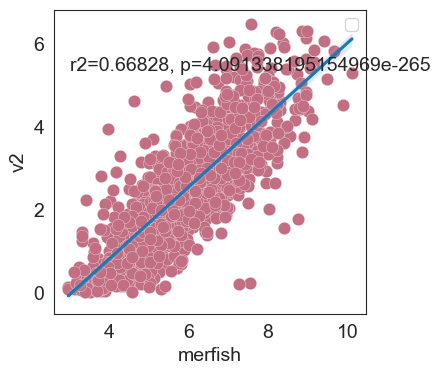

In [52]:
regplot(df=df2.loc[genes,:], x='merfish', y='v2', linewidth=0.2, c='#C26F83', rasterized=True, save='v2_merfish.pdf')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


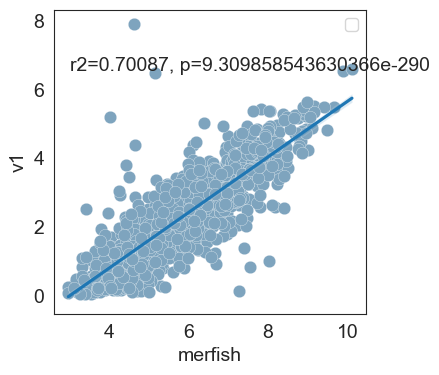

In [53]:
regplot(df=df2.loc[genes,:], x='merfish', y='v1', linewidth=0.2, c='#7EA4BE', rasterized=True, save='v1_merfish.pdf')

In [63]:
df2.sort_values(by='merfish').head(10)

D03558A5  C04027G3  Y00583N7  Y00583L7        v1        v2  \
Vsx2           0.286801  0.184708  0.143464  0.137519  0.235754  0.140491   
Nr5a1          0.058639  0.044095  0.070202  0.092903  0.051367  0.081552   
Mbnl3          0.216377  0.184708  0.472399  0.519679  0.200542  0.496039   
Trim54         0.323883  0.410233  0.108493  0.077577  0.367058  0.093035   
Nmur2          0.434073  0.489281  0.202766  0.258393  0.461677  0.230579   
Npffr2         0.095905  0.101716  0.295494  0.332883  0.098810  0.314189   
1700057H15Rik  0.338339  0.320313  0.529804  0.454755  0.329326  0.492279   
Trdn           0.373591  0.464800  0.591438  0.662778  0.419196  0.627108   
Lmod2          0.039472  0.038688  0.167981  0.187174  0.039080  0.177577   
Fgf3           0.216377  0.265667  0.090538  0.048855  0.241022  0.069696   

                merfish  
Vsx2           2.961177  
Nr5a1          2.963630  
Mbnl3          3.107198  
Trim54         3.124038  
Nmur2          3.156891  
Npffr2         3.182811  
1700057H15Rik  3.194551  
Trdn           3.219525  
Lmod2          3.258595  
Fgf3           3.292675

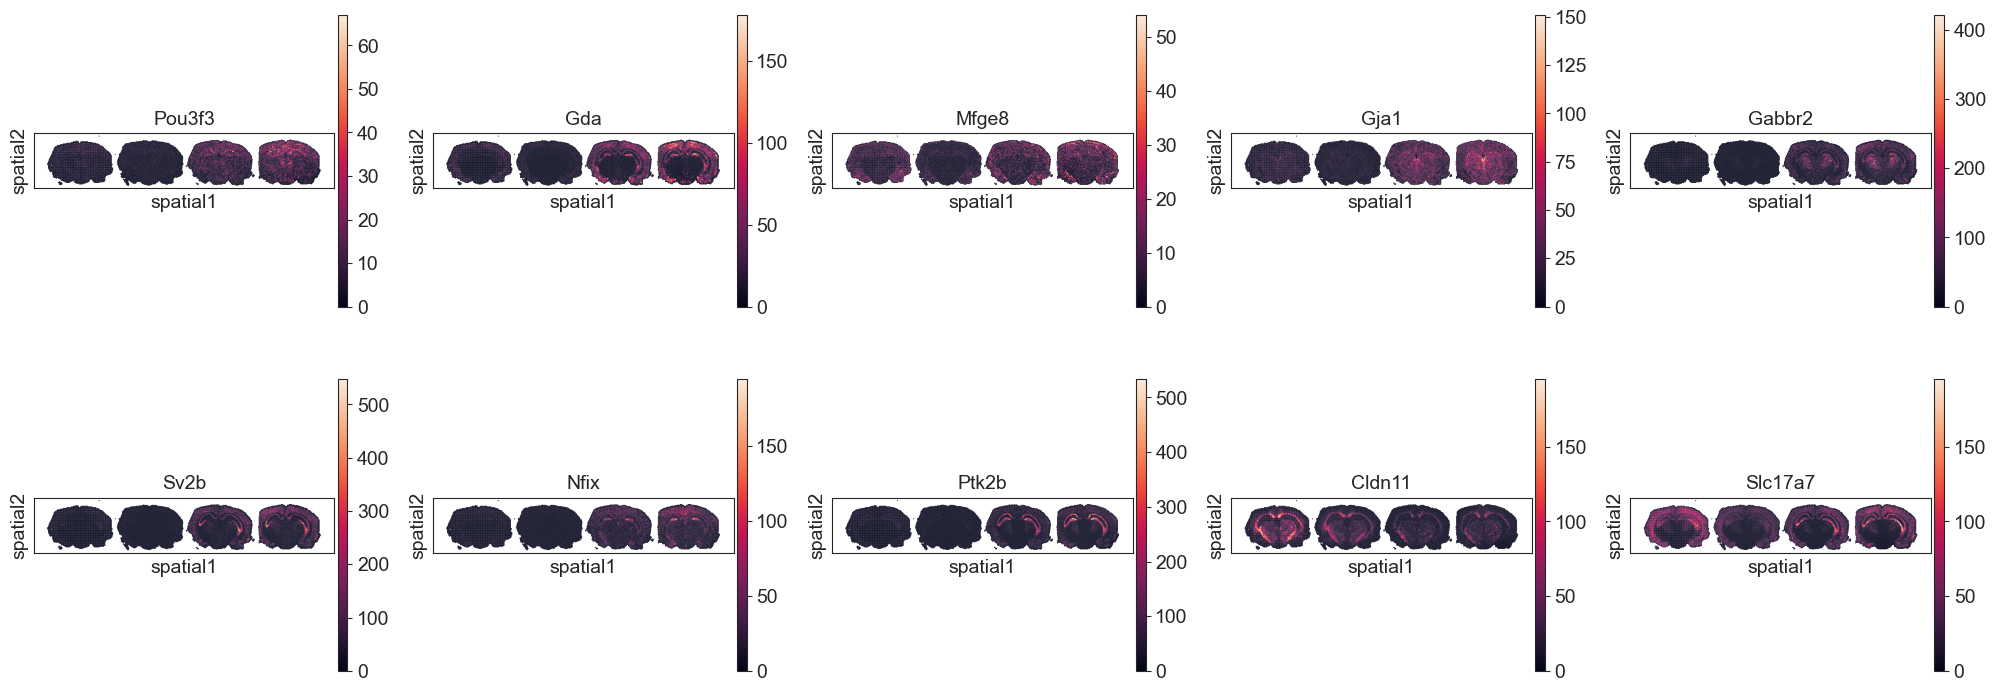

In [64]:
genes = df2.sort_values(by='merfish').tail(10).index
sc.pl.spatial(adata, color=genes, spot_size=280, ncols=5)

In [65]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

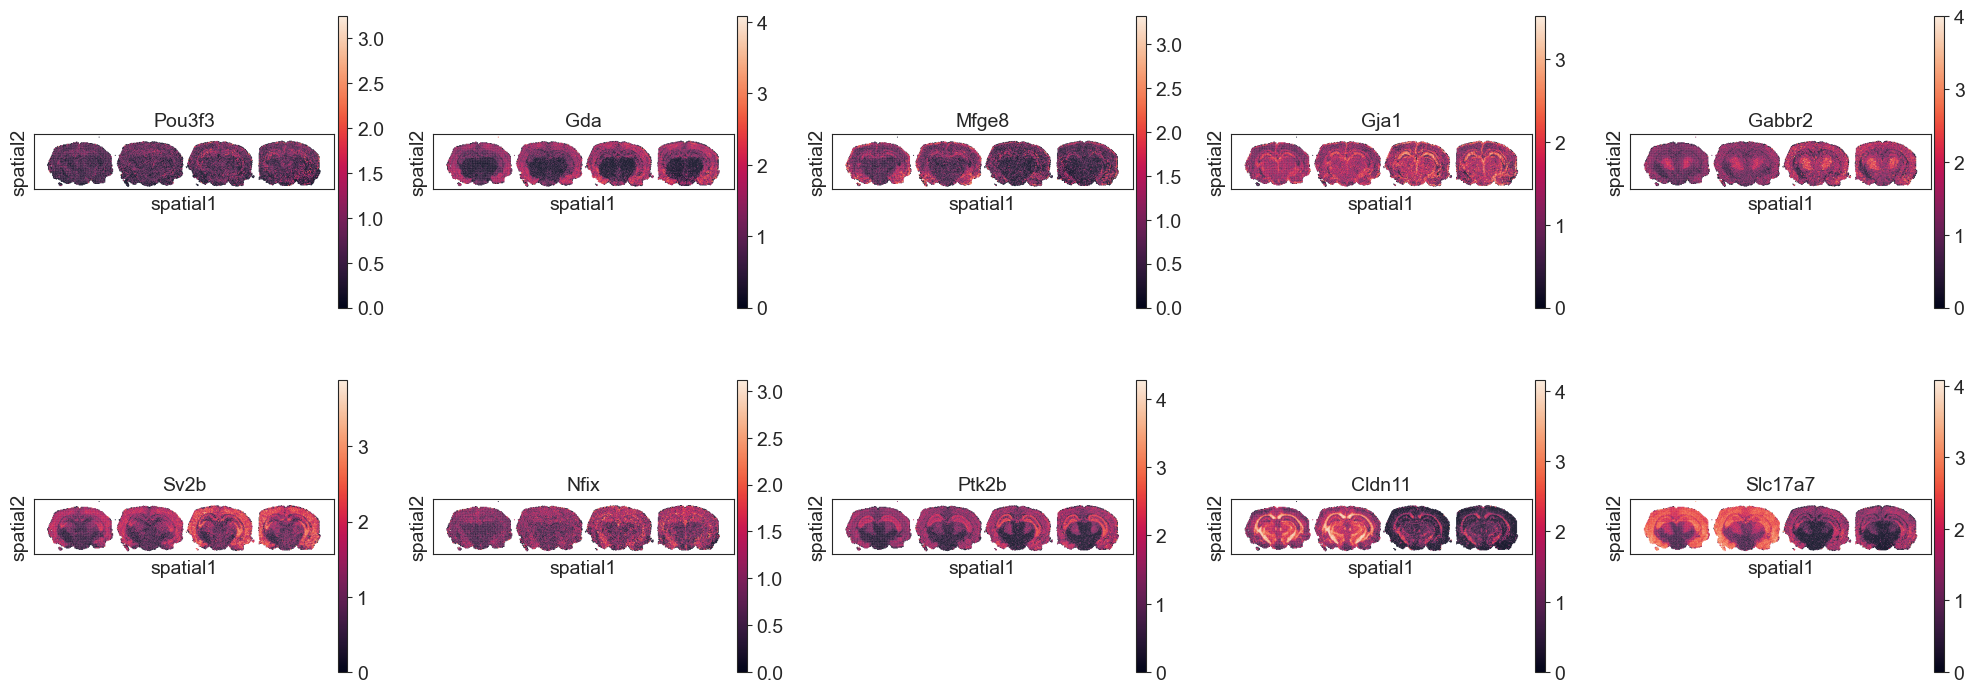

In [66]:
genes = df2.sort_values(by='merfish').tail(10).index
sc.pl.spatial(adata, color=genes, spot_size=280, ncols=5)

In [68]:
sub1.layers['counts'] = sub1.X.copy()

/tmp/ipykernel_3788236/2425596832.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  sub1.layers['counts'] = sub1.X.copy()


In [69]:
sc.pp.normalize_total(sub1, target_sum=1e3)
sc.pp.log1p(sub1)

In [102]:
sub1.obs.loc[sub1.obs['brain_section_label']=='Zhuang-ABCA-1.089', 'x'] = -sub1.obs.loc[sub1.obs['brain_section_label']=='Zhuang-ABCA-1.089', 'x'] 

In [105]:
sub1.obs['sample'] = sub1.obs['brain_section_label'].copy()
reloc(sub1,  arrange='h', gap=0.5)

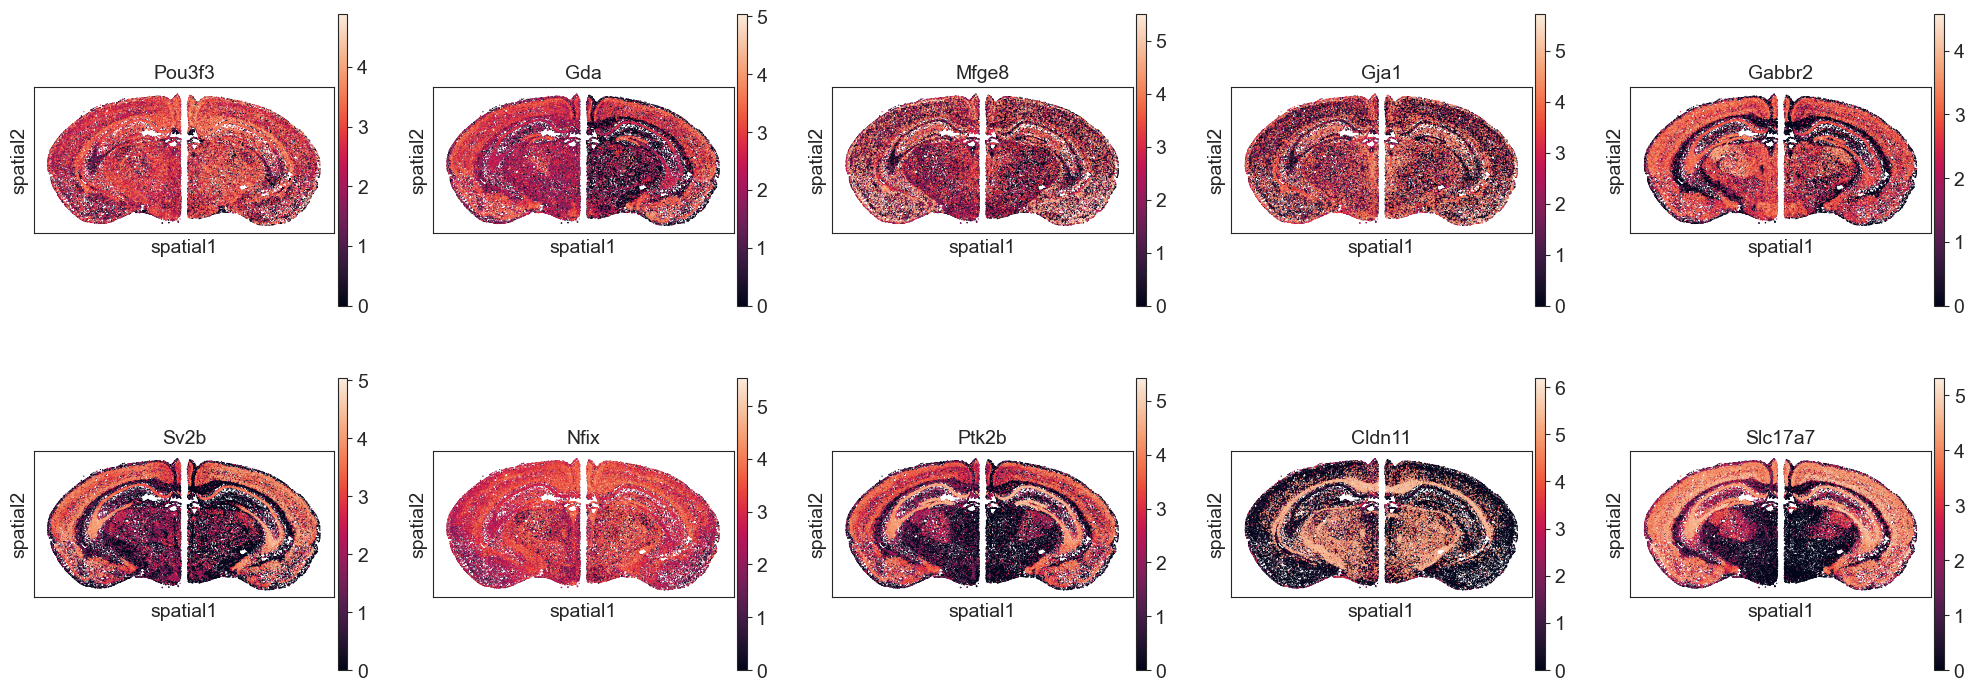

In [106]:
sc.pl.spatial(sub1, color=genes, spot_size=0.05, ncols=5)

In [108]:
sc.pp.scale(sub1)

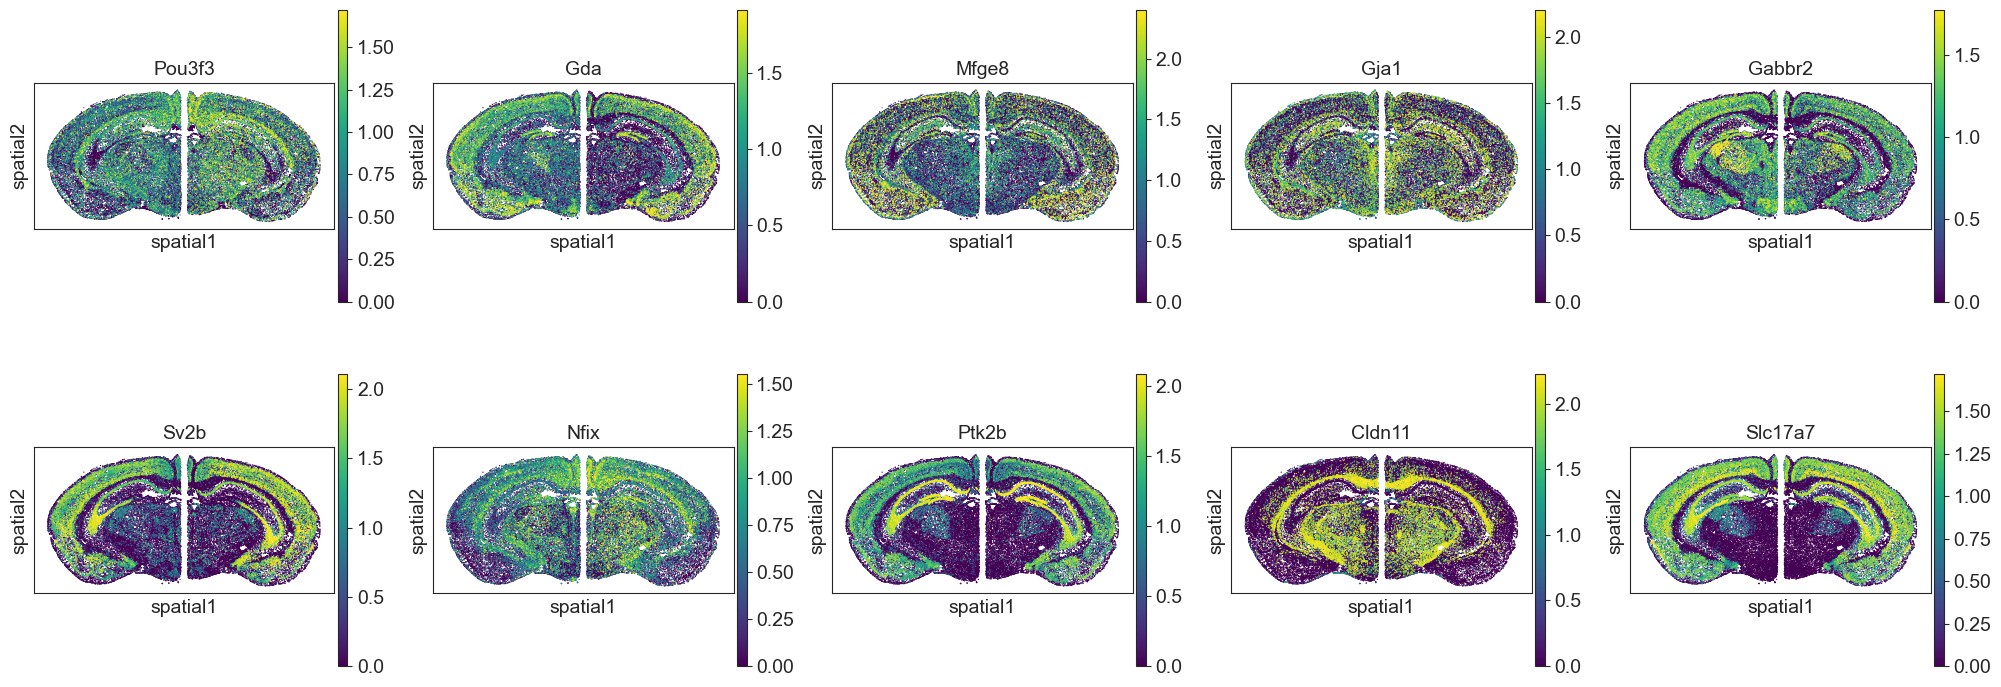

In [119]:
sc.pl.spatial(sub1, color=genes, spot_size=0.05, ncols=5, vmin=0, vmax='p99', cmap='viridis', save='merfish_markers.pdf')

In [116]:
st1 = adata[adata.obs['sample'].isin(['C04027G3', 'D03558A5']), genes].copy()
st2 = adata[adata.obs['sample'].isin(['Y00583L7', 'Y00583N7']), genes].copy()

sc.pp.scale(st1)
sc.pp.scale(st2)
adata_sub = sc.concat([st1, st2])

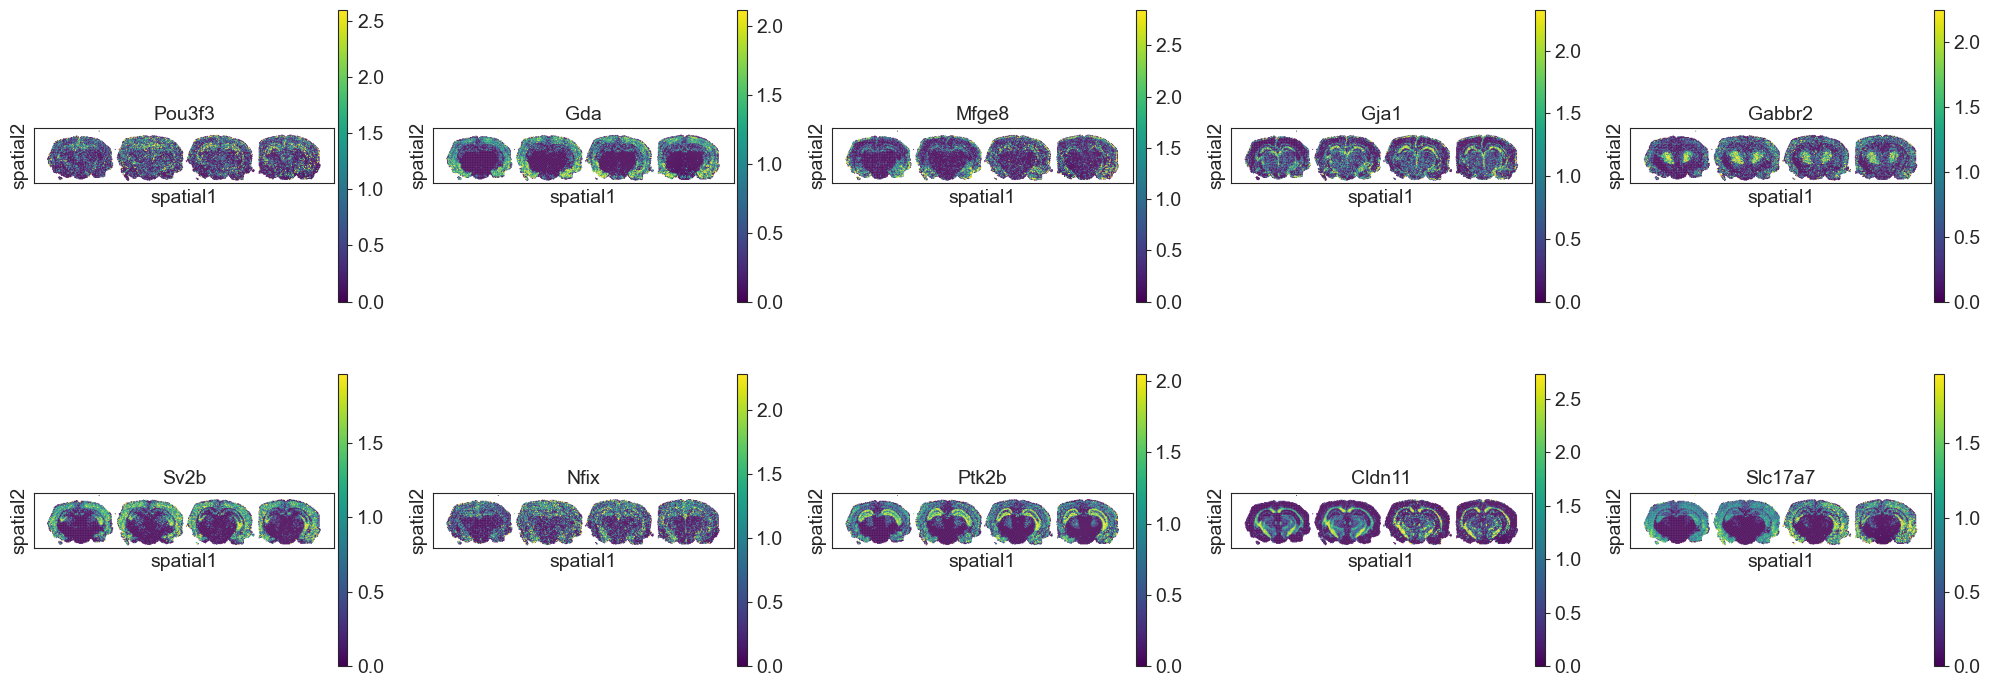

In [120]:
sc.pl.spatial(adata_sub, color=genes, spot_size=280, ncols=5, vmin=0, vmax='p99',cmap='viridis', save='stereo_markers.pdf')

# gene length

In [124]:
# gtffile = 'gencode.vM25.chr_patch_hapl_scaff.annotation.gtf'
! python /home/lee/codes/GTFtools_0.9.0/gtftools.py -l mm10_gene_length_gencode.vM25.txt gencode.vM25.chr_patch_hapl_scaff.annotation.gtf

Converting GTF to ENSEMBL format


In [141]:
gtf = pd.read_csv('mm10_gene_length_gencode.vM25.txt', sep='\t')
gtf.index = gtf['gene'].values
gtf

gene  mean  median  longest_isoform  \
ENSMUSG00000102693.1  ENSMUSG00000102693.1  1070    1070             1070   
ENSMUSG00000064842.1  ENSMUSG00000064842.1   110     110              110   
ENSMUSG00000051951.5  ENSMUSG00000051951.5  3592    3634             4153   
ENSMUSG00000102851.1  ENSMUSG00000102851.1   480     480              480   
ENSMUSG00000103377.1  ENSMUSG00000103377.1  2819    2819             2819   
...                                    ...   ...     ...              ...   
ENSMUSG00000095366.2  ENSMUSG00000095366.2   745     745             1181   
ENSMUSG00000095134.2  ENSMUSG00000095134.2  1248    1248             1248   
ENSMUSG00000096768.8  ENSMUSG00000096768.8  1178     774             3347   
ENSMUSG00000099871.1  ENSMUSG00000099871.1   548     548              548   
ENSMUSG00000096850.1  ENSMUSG00000096850.1   309     309              309   

                      merged                 ids  
ENSMUSG00000102693.1    1070  ENSMUSG00000102693  
ENSMUSG00000064842.1     110  ENSMUSG00000064842  
ENSMUSG00000051951.5    6094  ENSMUSG00000051951  
ENSMUSG00000102851.1     480  ENSMUSG00000102851  
ENSMUSG00000103377.1    2819  ENSMUSG00000103377  
...                      ...                 ...  
ENSMUSG00000095366.2    1181  ENSMUSG00000095366  
ENSMUSG00000095134.2    1248  ENSMUSG00000095134  
ENSMUSG00000096768.8    4501  ENSMUSG00000096768  
ENSMUSG00000099871.1     548  ENSMUSG00000099871  
ENSMUSG00000096850.1     309  ENSMUSG00000096850  

[55364 rows x 6 columns]

In [131]:
from gtfparse import read_gtf
mm_gtf = read_gtf('gencode.vM25.chr_patch_hapl_scaff.annotation.gtf')

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


In [145]:
symbols = mm_gtf[['gene_name', 'gene_id']].to_pandas().drop_duplicates()
symbols.index = symbols['gene_id'].values

In [151]:
gtf['symbol'] = symbols.loc[gtf.index, 'gene_name']
gtf = gtf[['mean', 'median', 'longest_isoform', 'merged', 'symbol']].groupby(by='symbol').mean()

In [152]:
gtf

mean  median  longest_isoform  merged
symbol                                                
0610005C13Rik   865.0   671.0           2434.0  3583.0
0610006L08Rik  1196.0  1196.0           1589.0  2128.0
0610009B22Rik   852.0   852.0            892.0   998.0
0610009E02Rik   915.0   600.0           1609.0  1803.0
0610009L18Rik   619.0   619.0            619.0   619.0
...               ...     ...              ...     ...
n-R5s96         124.0   124.0            124.0   124.0
n-R5s97         113.0   113.0            113.0   113.0
n-R5s98         119.0   119.0            119.0   119.0
n-TSaga9        107.0   107.0            107.0   107.0
n-TStga1        109.0   109.0            109.0   109.0

[55254 rows x 4 columns]

In [155]:
rlist = list()
chips = ['D03558A5', 'C04027G3','Y00583N7', 'Y00583L7']
for chip in chips:
    tmp = adata[adata.obs['sample']==chip]
    bulk = np.array(tmp.layers['counts'].sum(axis=0))[0, :]
    rlist.append(pd.Series(bulk, index=tmp.var_names))
df = pd.concat(rlist, axis=1)
df.columns=chips
df

D03558A5  C04027G3  Y00583N7  Y00583L7
0610005C13Rik       167       264        43        68
0610006L08Rik         6         6        26        28
0610009B22Rik      3800      7697      4126      3299
0610009O20Rik      1884      3172      7931      6259
0610010F05Rik      5205      8429     45392     35668
...                 ...       ...       ...       ...
mt-Nd3             1087      2754       439       410
mt-Nd4           210807    388505    209496    177284
mt-Nd4l               5        14        85        74
mt-Nd5            25831     50309    361121    302502
mt-Nd6             3967      7590     63129     53152

[22964 rows x 4 columns]

In [161]:
genes = set(gtf.index) & set(df.index)
df = df.loc[list(genes), :]
df

D03558A5  C04027G3  Y00583N7  Y00583L7
Prpsap2       1853      3372      9779      7658
Atp13a3       5257      8498     42334     33373
Gm48992        274       516       468       308
Pla2g2d         24        42        43        17
Gas1           887      1538      2434      2095
...            ...       ...       ...       ...
Nol11         2341      4068      9214      7729
Gm45083         13        47       284       283
Slc25a15      1484      2459      7145      5571
Gm29155         91       117       205       194
Golim4        1794      3047     24826     20279

[22115 rows x 4 columns]

In [162]:
df2 = df * 1e6 / df.sum()
df2 = df2.applymap(np.log1p)
df2

D03558A5  C04027G3  Y00583N7  Y00583L7
Prpsap2   3.092483  3.096073  3.137648  3.126931
Atp13a3   4.105407  3.992738  4.569069  4.564554
Gm48992   1.413405  1.442321  0.720393  0.629642
Pla2g2d   0.240907  0.233449  0.092539  0.047268
Gas1      2.404015  2.363577  1.869979  1.940882
...            ...       ...       ...       ...
Nol11     3.316748  3.275951  3.080792  3.135757
Gm45083   0.137630  0.257932  0.494916  0.590981
Slc25a15  2.881641  2.796974  2.839691  2.825049
Gm29155   0.709443  0.549564  0.379964  0.439775
Golim4    3.061616  2.999537  4.042655  4.073094

[22115 rows x 4 columns]

In [167]:
df3 = df.copy()
df3[['mean', 'median', 'longest_isoform', 'merged']] = gtf.loc[df3.index, ['mean', 'median', 'longest_isoform', 'merged']]
df3 = ((df3.T * 1e6) * 1e3 / df3['mean'] ).T /df3.sum()
df3 = df3.applymap(np.log1p)
df3

D03558A5  C04027G3  Y00583N7  Y00583L7      mean    median  \
Prpsap2   2.737276  2.740794  2.781545  2.771037  3.183361  3.439821   
Atp13a3   3.199822  3.090094  3.654280  3.649836  3.183361  2.266364   
Gm48992   1.341463  1.369695  0.672148  0.585836  3.183361  3.261255   
Pla2g2d   0.149770  0.144931  0.055914  0.028304  3.183361  3.261255   
Gas1      1.773578  1.736734  1.299304  1.360564  3.183361  3.261255   
...            ...       ...       ...       ...       ...       ...   
Nol11     2.658300  2.618961  2.431632  2.484242  3.183361  3.551837   
Gm45083   0.188332  0.345909  0.641529  0.756912  3.183361  3.261255   
Slc25a15  1.665040  1.592759  1.629114  1.616627  3.183361  3.261255   
Gm29155   1.661652  1.392984  1.068170  1.188596  3.183361  3.261255   
Golim4    2.159125  2.101645  3.094124  3.123716  3.183361  3.018736   

          longest_isoform    merged  
Prpsap2          2.922304  2.719986  
Atp13a3          3.717795  3.743307  
Gm48992          2.703846  2.444350  
Pla2g2d          2.939859  2.708019  
Gas1             3.047010  2.781320  
...                   ...       ...  
Nol11            3.134827  3.372724  
Gm45083          2.703846  2.444350  
Slc25a15         2.816021  2.777099  
Gm29155          2.802877  3.040492  
Golim4           3.404229  3.803339  

[22115 rows x 8 columns]

In [172]:
df_norm = pd.DataFrame()
df_norm['v1_noLen'] = df2[['D03558A5', 'C04027G3']].mean(axis=1)
df_norm['v2_noLen'] = df2[['Y00583N7', 'Y00583L7']].mean(axis=1)
df_norm['v1_Len'] = df3[['D03558A5', 'C04027G3']].mean(axis=1)
df_norm['v2_Len'] = df3[['Y00583N7', 'Y00583L7']].mean(axis=1)
df_norm

v1_noLen  v2_noLen    v1_Len    v2_Len
Prpsap2   3.094278  3.132289  2.739035  2.776291
Atp13a3   4.049072  4.566811  3.144958  3.652058
Gm48992   1.427863  0.675018  1.355579  0.628992
Pla2g2d   0.237178  0.069903  0.147350  0.042109
Gas1      2.383796  1.905430  1.755156  1.329934
...            ...       ...       ...       ...
Nol11     3.296349  3.108274  2.638631  2.457937
Gm45083   0.197781  0.542948  0.267121  0.699220
Slc25a15  2.839308  2.832370  1.628899  1.622871
Gm29155   0.629503  0.409869  1.527318  1.128383
Golim4    3.030577  4.057875  2.130385  3.108920

[22115 rows x 4 columns]

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 23 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'L', 'comma', 'e', 'eight', 'equal', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 'six', 'space', 'three', 'two', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 17, 19, 20, 21, 22, 23, 24, 25, 27, 32, 47, 66, 72, 81, 82, 83, 85, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 23 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'L', 'comma'

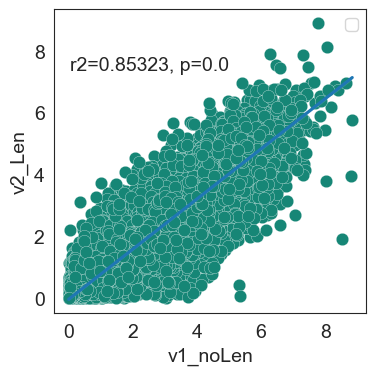

In [180]:
regplot(df=df_norm, x='v1_noLen', y='v2_Len', linewidth=0.2, c='#168676', save='v1_v2_len.pdf')

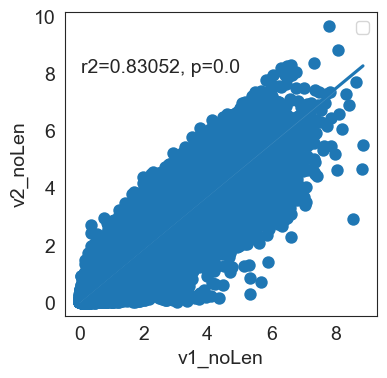

In [174]:
regplot(df=df_norm, x='v1_noLen', y='v2_noLen')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 23 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'L', 'comma', 'e', 'eight', 'equal', 'four', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 'six', 'space', 'three', 'two', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 17, 19, 20, 21, 22, 23, 25, 27, 28, 32, 47, 66, 72, 81, 82, 83, 85, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 23 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'L', 'comma'

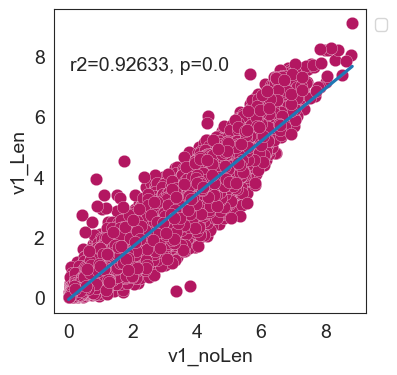

In [182]:
regplot(df=df_norm, x='v1_noLen', y='v1_Len', linewidth=0.2, c='#b31761', save='v1_v1_len.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 25 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'L', 'comma', 'e', 'eight', 'equal', 'five', 'four', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 'seven', 'six', 'space', 'three', 'two', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 47, 66, 72, 81, 82, 83, 85, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 25 glyphs after
INFO:fontTools.subset:Glyph names: ['.notde

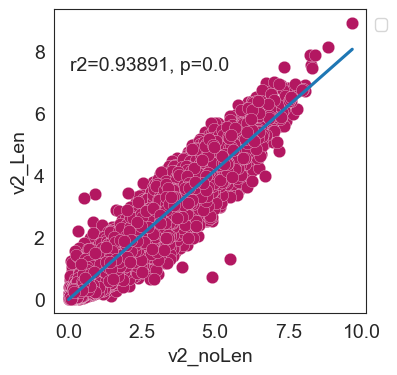

In [181]:
regplot(df=df_norm, x='v2_noLen', y='v2_Len', linewidth=0.2, c='#b31761', save='v2_v2_len.pdf')

In [184]:
adata.write('fresh_mouse_brain_v1-v2_bin200.h5ad')